In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as SM
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [4]:
def outlier_iqr(data):
    """
    Calculating the IQR stats
    """
    Q1 = np.percentile(data, 25)  
    Q3 = np.percentile(data, 75)  
    IQR = Q3 - Q1  
    
    # Calculate lower and upper whiskers
    lower_whisker = Q1 - 1.5 * IQR  
    upper_whisker = Q3 + 1.5 * IQR  
    
    print("Q1:", Q1, "Q3:", Q3, "IQR:", IQR)
    print("Lower Whisker:", lower_whisker, "Upper Whisker:", upper_whisker)
    return upper_whisker

In [5]:
def outlier_winsorize(data, lower_limit=5, upper_limit=95):
    """
    Apply 90% Winsorization to input data (replaces extremes at 5th and 95th percentiles).
    
    Parameters:
    data (array-like): Input data to be winsorized
    lower_limit (float): Lower percentile cutoff (default=5)
    upper_limit (float): Upper percentile cutoff (default=95)
    
    Returns:
    np.ndarray: Winsorized data
    """
    data = np.asarray(data)
    lower = np.nanpercentile(data, lower_limit)
    upper = np.nanpercentile(data, upper_limit)
    return np.clip(data, lower, upper)

In [6]:
# Loading features
housing = fetch_california_housing()

In [7]:
data = pd.DataFrame(housing.data)
data.columns = housing.feature_names

In [8]:
# loading target column
data['Price_in_100k'] = housing.target

### Feature description

- MedInc: median income in block group.
- HouseAge: median house age in block group.
- AveRooms: average number of rooms per household.
- AveBedrms: average number of bedrooms per household.
- Population: block group population.
- AveOccup: average number of household members.
- Latitude: block group latitude.
- Longitude: block group longitude.

## Exploratory Data Analysis

In [11]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price_in_100k
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
data.shape

(20640, 9)

In [13]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price_in_100k'],
      dtype='object')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  float64
 2   AveRooms       20640 non-null  float64
 3   AveBedrms      20640 non-null  float64
 4   Population     20640 non-null  float64
 5   AveOccup       20640 non-null  float64
 6   Latitude       20640 non-null  float64
 7   Longitude      20640 non-null  float64
 8   Price_in_100k  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [15]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price_in_100k
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [16]:
# Checking null values
data.isnull().sum().sort_values(ascending = False)

MedInc           0
HouseAge         0
AveRooms         0
AveBedrms        0
Population       0
AveOccup         0
Latitude         0
Longitude        0
Price_in_100k    0
dtype: int64

In [17]:
# Checking duplicates
duplicate = data[data.duplicated()] 
duplicate

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price_in_100k


In [18]:
# Converting wrongly tagged data types of select columns.
data = data.astype({'HouseAge': int, 'Population': int})

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  int64  
 2   AveRooms       20640 non-null  float64
 3   AveBedrms      20640 non-null  float64
 4   Population     20640 non-null  int64  
 5   AveOccup       20640 non-null  float64
 6   Latitude       20640 non-null  float64
 7   Longitude      20640 non-null  float64
 8   Price_in_100k  20640 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.4 MB


### Target variable distribution

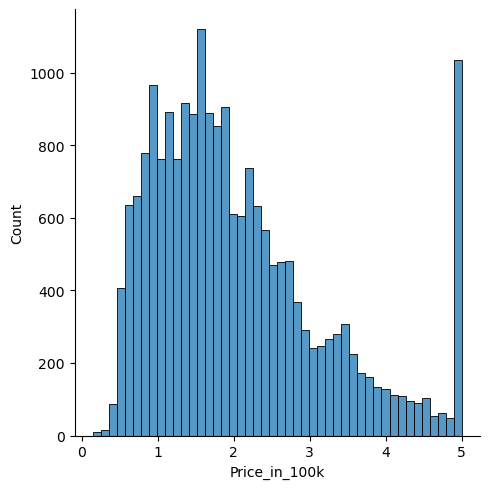

In [21]:
sns.displot(data['Price_in_100k'])

<Axes: xlabel='Price_in_100k'>

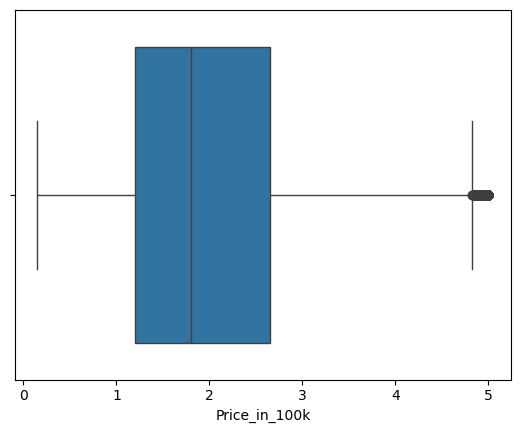

In [22]:
sns.boxplot(data['Price_in_100k'], orient='h')

In [23]:
data['Price_in_100k'].skew()
# moderately scewed data

0.9777632739098345

### Analysing feature: MedInc

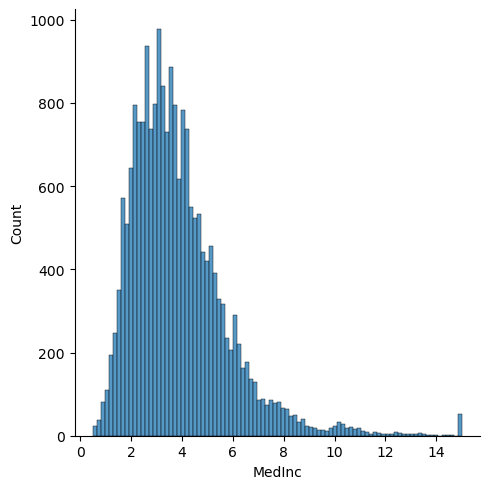

In [25]:
sns.displot(data['MedInc'])

<Axes: xlabel='MedInc'>

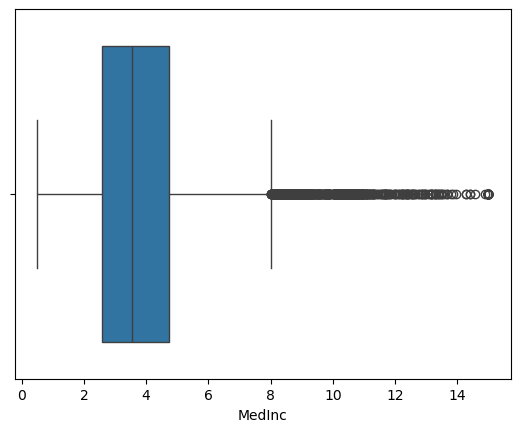

In [26]:
sns.boxplot(data['MedInc'], orient='h')

In [27]:
data['MedInc'].skew()
# Right skewed

1.6466567021344465

### Analysing feature: MedInc after outlier treatment

In [29]:
win_data = pd.DataFrame(outlier_winsorize(data['MedInc']))
data['MedInc'] = win_data.values

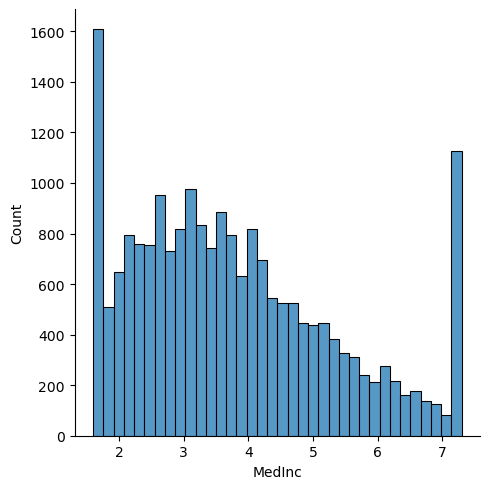

In [30]:
sns.displot(data['MedInc'])

<Axes: xlabel='MedInc'>

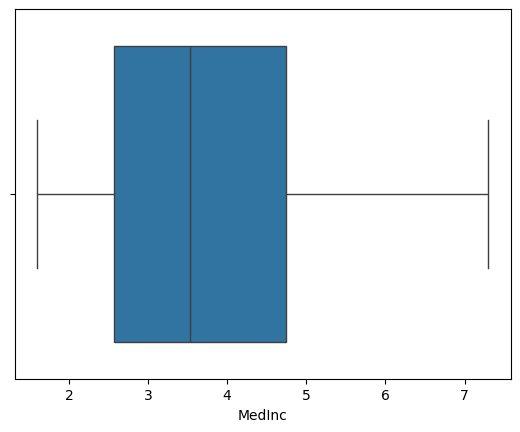

In [31]:
sns.boxplot(data['MedInc'], orient='h')

### Analysing feature: HouseAge

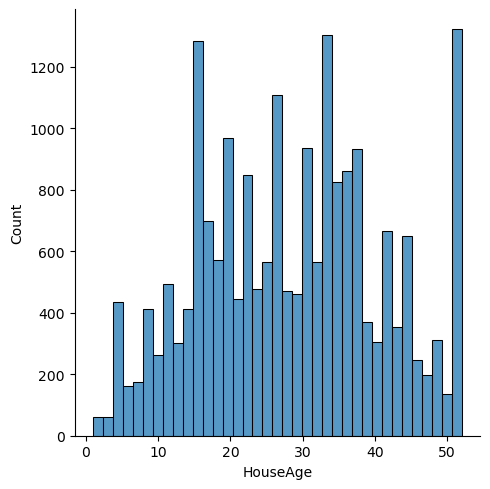

In [33]:
sns.displot(data['HouseAge'])

<Axes: xlabel='HouseAge'>

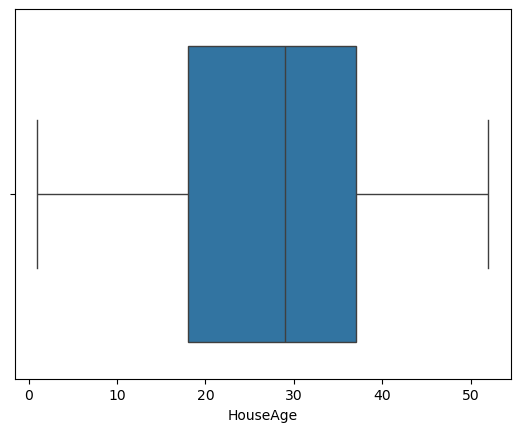

In [34]:
sns.boxplot(data['HouseAge'], orient = 'h')

### Analysing feature: AveRooms

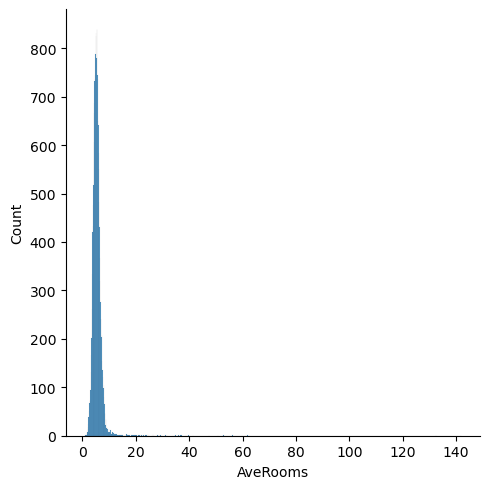

In [36]:
sns.displot(data['AveRooms'])

<Axes: xlabel='AveRooms'>

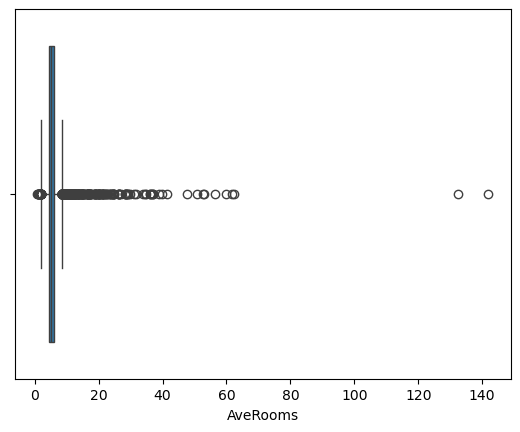

In [37]:
sns.boxplot(data['AveRooms'], orient = 'h')

In [38]:
data['AveRooms'].skew()
# Highly right skewed

20.697868956710646

### Analysing feature: AveRooms after outlier treatment

In [40]:
upper_limit = outlier_iqr(data['AveRooms'])

Q1: 4.440716235896959 Q3: 6.052380952380952 IQR: 1.6116647164839932
Lower Whisker: 2.023219161170969 Upper Whisker: 8.469878027106942


In [41]:
# Removing all the data higher than upper whsiker
data = data[data['AveRooms'] < upper_limit]

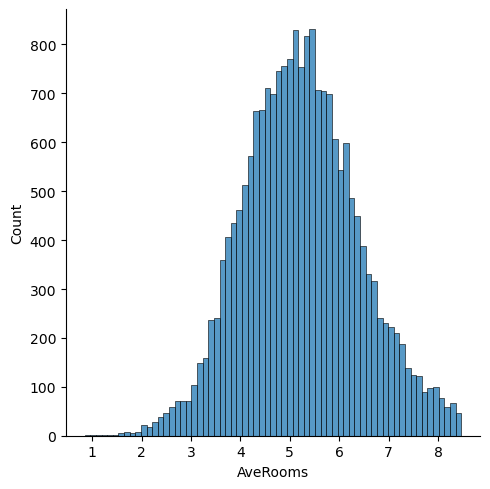

In [42]:
sns.displot(data['AveRooms'])

<Axes: xlabel='AveRooms'>

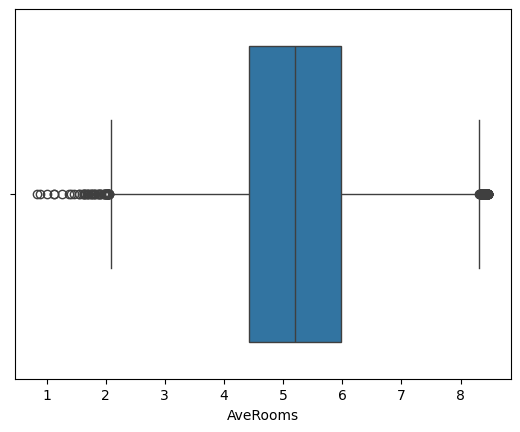

In [43]:
sns.boxplot(data['AveRooms'], orient = 'h')

In [44]:
data['AveRooms'].skew()
# Highly right skewed

0.14569497123326713

### Analysing feature: AveBedrms

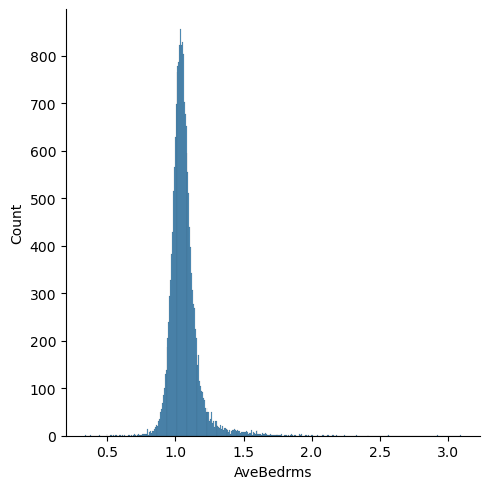

In [46]:
sns.displot(data['AveBedrms'])

<Axes: xlabel='AveBedrms'>

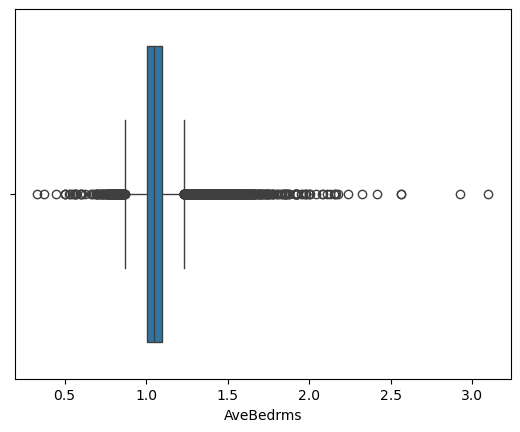

In [47]:
sns.boxplot(data['AveBedrms'], orient = 'h')

In [48]:
data['AveBedrms'].skew()
# Highly right skewed

3.2503300288066157

### Analysing feature: Population

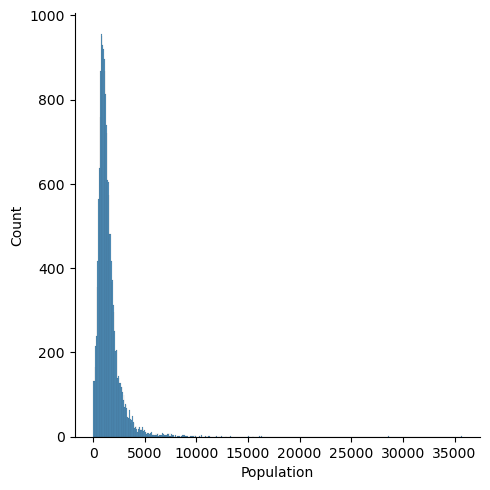

In [50]:
sns.displot(data['Population'])

<Axes: xlabel='Population'>

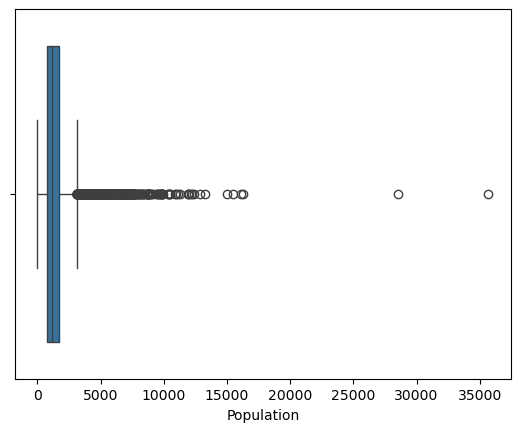

In [51]:
sns.boxplot(data['Population'], orient = 'h')

### Analysing feature: AveOccup

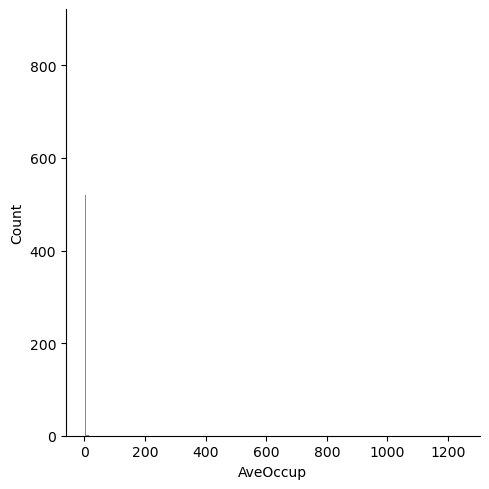

In [53]:
sns.displot(data['AveOccup'])

<Axes: xlabel='AveOccup'>

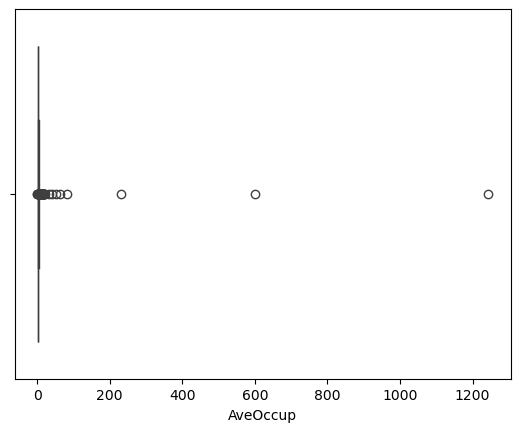

In [54]:
sns.boxplot(data['AveOccup'], orient = 'h')

### Analysing feature: AveOccup after outlier treatment

In [56]:
cap = np.percentile(data['AveOccup'], 99)

In [57]:
data = data[data['AveOccup'] < cap]

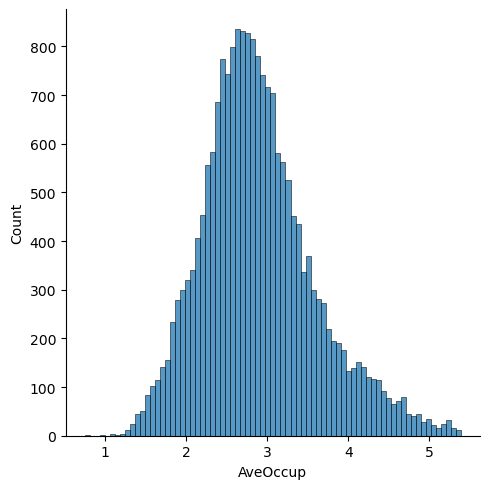

In [58]:
sns.displot(data['AveOccup'])

<Axes: xlabel='AveOccup'>

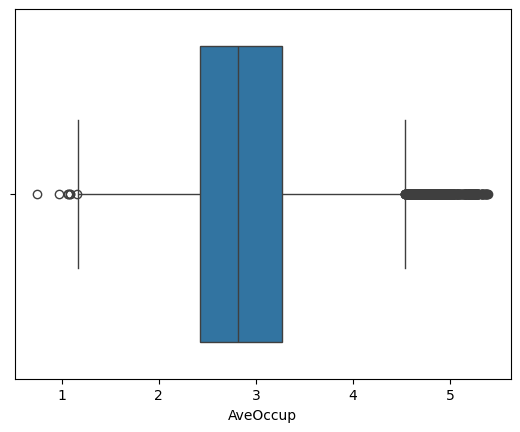

In [59]:
sns.boxplot(data['AveOccup'], orient = 'h')

In [60]:
# Adding new feature houses
data['Houses'] = data['Population']/ data['AveOccup']

### Analysing feature: Houses

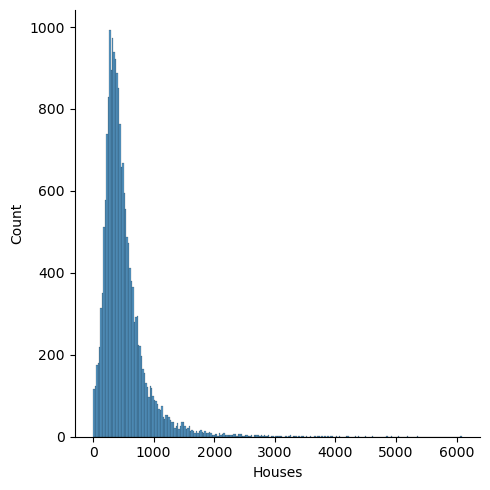

In [62]:
sns.displot(data['Houses'])

<Axes: xlabel='Houses'>

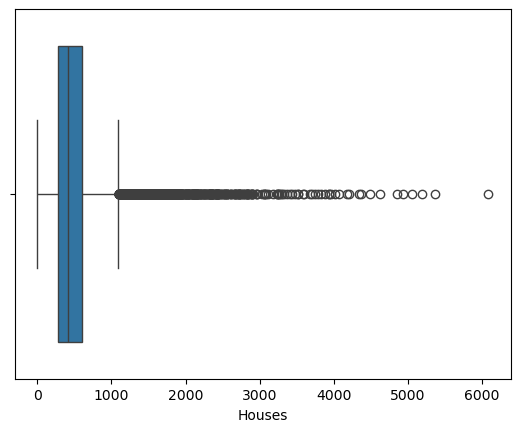

In [63]:
sns.boxplot(data['Houses'], orient = 'h')

In [64]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price_in_100k,Houses
count,19972.000000,19972.000000,19972.000000,19972.000000,19972.000000,19972.000000,19972.000000,19972.000000,19972.000000,19972.000000
mean,3.767203,28.815742,5.238001,1.062101,1430.165181,2.894084,35.626536,-119.584620,2.059050,505.612057
std,1.542020,12.516447,1.161811,0.111731,1097.194228,0.696765,2.130412,2.001742,1.138688,381.437128
min,1.600570,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990,2.000000
25%,2.558800,18.000000,4.430393,1.005013,798.000000,2.428571,33.930000,-121.810000,1.193000,285.000000
50%,3.526800,29.000000,5.201037,1.047289,1173.000000,2.813528,34.250000,-118.500000,1.803000,414.000000
75%,4.722200,37.000000,5.987002,1.095890,1726.250000,3.270292,37.710000,-118.020000,2.639250,609.000000
max,7.300305,52.000000,8.469738,3.099338,28566.000000,5.392384,41.950000,-114.550000,5.000010,6082.000000


### Checking multicorrelation amoung features

In [66]:
house_corr1 = data.corr(method ='pearson')
house_corr1

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price_in_100k,Houses
MedInc,1.000000,-0.146050,0.681968,-0.228192,0.025036,-0.080595,-0.081321,-0.020180,0.676003,0.034548
HouseAge,-0.146050,1.000000,-0.213080,-0.107401,-0.314878,-0.012277,0.013217,-0.103541,0.110093,-0.313815
AveRooms,0.681968,-0.213080,1.000000,0.146934,-0.025502,-0.016234,0.127961,-0.090050,0.311957,-0.051356
AveBedrms,-0.228192,-0.107401,0.146934,1.000000,-0.014554,-0.110367,0.066912,-0.002361,-0.106321,0.023624
Population,0.025036,-0.314878,-0.025502,-0.014554,1.000000,0.181784,-0.104611,0.102536,-0.024112,0.925157
AveOccup,-0.080595,-0.012277,-0.016234,-0.110367,0.181784,1.000000,-0.168913,0.185299,-0.297757,-0.124618
Latitude,-0.081321,0.013217,0.127961,0.066912,-0.104611,-0.168913,1.000000,-0.929316,-0.143099,-0.064566
Longitude,-0.020180,-0.103541,-0.090050,-0.002361,0.102536,0.185299,-0.929316,1.000000,-0.046346,0.055007
Price_in_100k,0.676003,0.110093,0.311957,-0.106321,-0.024112,-0.297757,-0.143099,-0.046346,1.000000,0.069445
Houses,0.034548,-0.313815,-0.051356,0.023624,0.925157,-0.124618,-0.064566,0.055007,0.069445,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

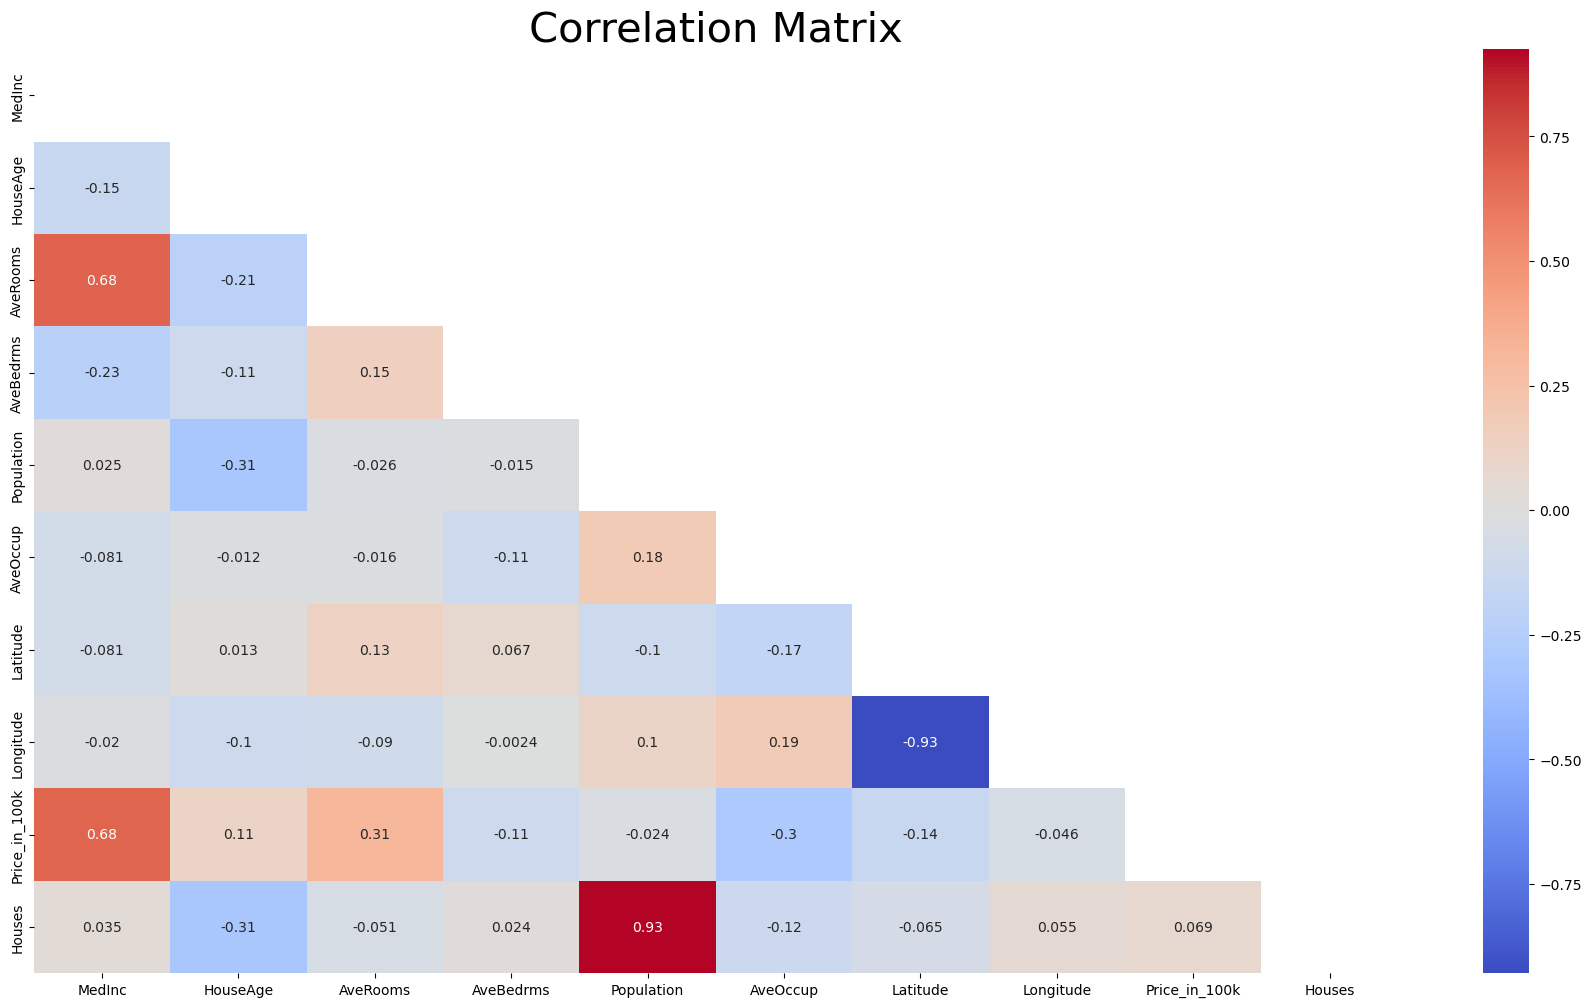

In [67]:
# Plotting heatmap
plt.subplots(figsize =(22, 12)) 
sns.heatmap(house_corr1,cmap="coolwarm",annot=True, mask = np.triu(np.ones_like(house_corr1, dtype=bool)))
plt.title("Correlation Matrix", size=30)

Text(0.5, 1.0, 'Correlation with Price Variable')

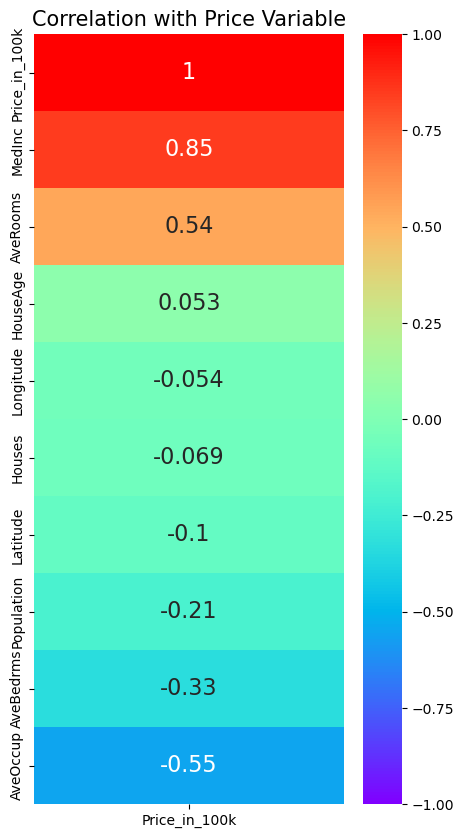

In [68]:
top_features = house_corr1.corr()[['Price_in_100k']].sort_values(by=['Price_in_100k'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)
plt.title("Correlation with Price Variable", size=15)

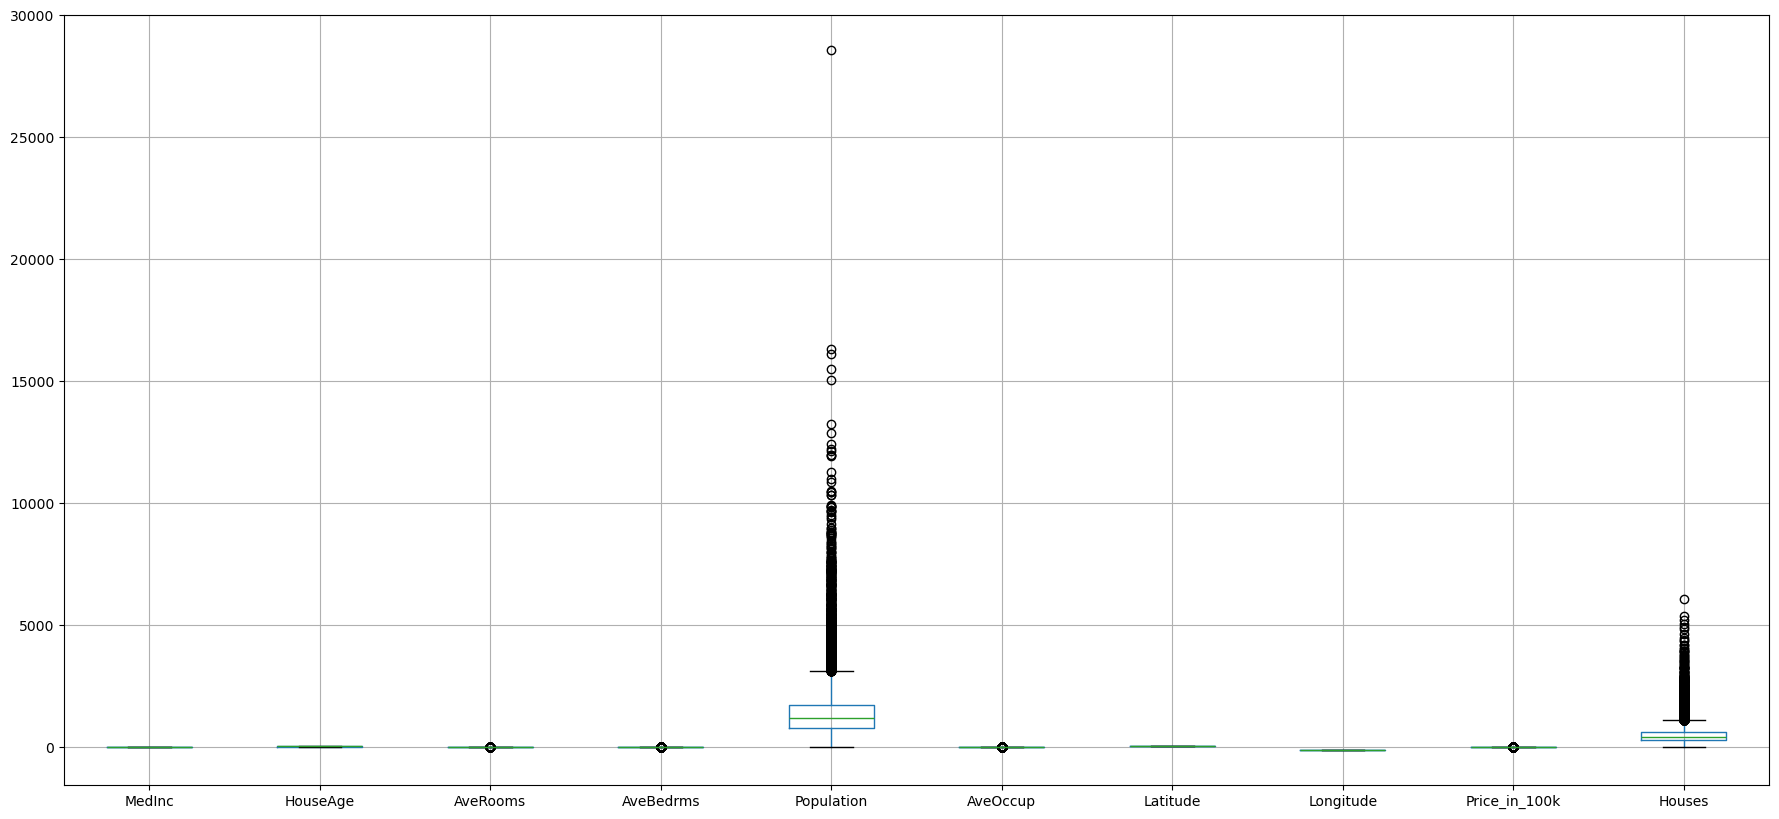

In [69]:
plt.figure(figsize=(22,10))
data.boxplot();

## Linear Regression Model training 

In [71]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [72]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price_in_100k', 'Houses'],
      dtype='object')

 #### All features

In [74]:
f_1 = 'Price_in_100k~MedInc+HouseAge+AveRooms+AveBedrms+Population+AveOccup+Latitude+Longitude+Houses'

In [75]:
model_1 = SM.ols(f_1,train_df).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     3388.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        11:28:10   Log-Likelihood:                -16233.
No. Observations:               15977   AIC:                         3.249e+04
Df Residuals:                   15967   BIC:                         3.256e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.6088      0.730    -44.684      0.000     -34.039     -31.178
MedInc         0.5264      0.006     85.585      0.000       0.514       0.538
HouseAge       0.0135      0.000     28.257      0.000       0.013       0.014
AveRooms      -0.1215      0.008    -15.561      0.000      -0.137      -0.106
AveBedrms      1.1277      0.055     20.631      0.000       1.021       1.235
Population    -0.0001   2.05e-05     -5.271      0.000      -0.000   -6.78e-05
AveOccup      -0.3091      0.013    -24.569      0.000      -0.334      -0.284
Latitude      -0.4018      0.008    -50.062      0.000      -0.418      -0.386
Longitude     -0.3920      0.008    -47.172      0.000      -0.408      -0.376
Houses         0.0004   5.87e-05      7.284      0.000       0.000       0.001
==============================================================================
Omnibus:                     2428.160   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5481.354
Skew:                           0.891   Prob(JB):                         0.00
Kurtosis:                       5.249   Cond. No.                     2.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
model_1.rsquared_adj

0.6561350529016268

In [146]:
model_name = []
model_perf = []

model_name.append('All Variables')
model_perf.append(model_1.rsquared_adj)

#### Drop - House age, Longitude, Houses

In [77]:
f_2 = 'Price_in_100k~MedInc+AveRooms+AveBedrms+Population+AveOccup+Latitude'

In [78]:
model_2 = SM.ols(f_2,train_df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     3515.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        11:28:10   Log-Likelihood:                -18041.
No. Observations:               15977   AIC:                         3.610e+04
Df Residuals:                   15970   BIC:                         3.615e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5378      0.133     19.099      0.000       2.277       2.798
MedInc         0.6499      0.006    104.597      0.000       0.638       0.662
AveRooms      -0.2944      0.008    -36.413      0.000      -0.310      -0.279
AveBedrms      1.1757      0.061     19.370      0.000       1.057       1.295
Population -2.053e-05   5.45e-06     -3.763      0.000   -3.12e-05   -9.83e-06
AveOccup      -0.3722      0.009    -41.259      0.000      -0.390      -0.355
Latitude      -0.0429      0.003    -14.488      0.000      -0.049      -0.037
==============================================================================
Omnibus:                     2085.337   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4207.847
Skew:                           0.817   Prob(JB):                         0.00
Kurtosis:                       4.911   Cond. No.                     4.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [148]:
model_name.append('Drop-House age, Longitude, Houses')
model_perf.append(model_2.rsquared_adj)

#### Drop - HouseAge, Longitude, Latitude

In [80]:
f_3 = 'Price_in_100k~MedInc+AveRooms+AveBedrms+Population+AveOccup+Houses'

In [81]:
model_3 = SM.ols(f_3,train_df).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     3442.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        11:28:10   Log-Likelihood:                -18135.
No. Observations:               15977   AIC:                         3.628e+04
Df Residuals:                   15970   BIC:                         3.634e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7710      0.079      9.762      0.000       0.616       0.926
MedInc         0.6723      0.006    111.470      0.000       0.661       0.684
AveRooms      -0.3220      0.008    -40.805      0.000      -0.337      -0.307
AveBedrms      1.2417      0.061     20.382      0.000       1.122       1.361
Population    -0.0001   2.31e-05     -5.068      0.000      -0.000   -7.16e-05
AveOccup      -0.2970      0.014    -21.208      0.000      -0.324      -0.270
Houses         0.0003   6.59e-05      4.483      0.000       0.000       0.000
==============================================================================
Omnibus:                     2077.390   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4170.667
Skew:                           0.816   Prob(JB):                         0.00
Kurtosis:                       4.898   Cond. No.                     3.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model_name.append('Drop-HouseAge, Longitude, Latitude')
model_perf.append(model_3.rsquared_adj)

In [153]:
model_eval = pd.DataFrame({'model_name': model_name, 'model_perf': model_perf})
model_eval

,model_name,model_perf
0,All Variables,0.656135
1,"Drop-House age, Longitude, Houses",0.568896
2,"Drop-HouseAge, Longitude, Latitude",0.563779


### Calculating VIF of variables

In [158]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df.columns

In [160]:
train_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price_in_100k', 'Houses'],
      dtype='object')

In [162]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df.values, i)
                          for i in range(len(train_df.columns))]

In [164]:
vif_data

,feature,VIF
0,MedInc,32.353560
1,HouseAge,8.316431
2,AveRooms,60.161754
3,AveBedrms,124.689429
4,Population,49.156571
5,AveOccup,52.003167
6,Latitude,654.513461
7,Longitude,1061.758002
8,Price_in_100k,11.013680
9,Houses,50.020234


## Model by dropping high VIF value variable(i.e, Longitude)

In [167]:
f_4 = 'Price_in_100k~MedInc+HouseAge+AveRooms+AveBedrms+Population+AveOccup+Latitude+Houses'

In [169]:
model_4 = SM.ols(f_4,train_df).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     3101.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        11:56:54   Log-Likelihood:                -17275.
No. Observations:               15977   AIC:                         3.457e+04
Df Residuals:                   15968   BIC:                         3.464e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3037      0.134      9.743      0.000       1.041       1.566
MedInc         0.6504      0.006    109.611      0.000       0.639       0.662
HouseAge       0.0196      0.000     39.835      0.000       0.019       0.021
AveRooms      -0.2446      0.008    -31.134      0.000      -0.260      -0.229
AveBedrms      1.3318      0.058     22.899      0.000       1.218       1.446
Population    -0.0001   2.19e-05     -4.582      0.000      -0.000   -5.73e-05
AveOccup      -0.3098      0.013    -23.073      0.000      -0.336      -0.284
Latitude      -0.0443      0.003    -15.707      0.000      -0.050      -0.039
Houses         0.0004   6.26e-05      7.131      0.000       0.000       0.001
==============================================================================
Omnibus:                     2304.786   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5234.730
Skew:                           0.849   Prob(JB):                         0.00
Kurtosis:                       5.232   Cond. No.                     4.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [181]:
model_name.append('Drop- Longitude')
model_perf.append(model_4.rsquared_adj)

In [183]:
train_df2 = train_df[['Price_in_100k', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Houses']]

In [197]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df2.columns

In [199]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df2.values, i)
                          for i in range(len(train_df2.columns))]
vif_data

,feature,VIF
0,Price_in_100k,10.811058
1,MedInc,30.275920
2,HouseAge,7.997283
3,AveRooms,57.259149
4,AveBedrms,95.911162
5,Population,46.821474
6,AveOccup,40.889608
7,Latitude,115.770948
8,Houses,46.836051


## Model by dropping high VIF value variable(i.e, Longitude, Latitude)

In [203]:
f_5 = 'Price_in_100k~MedInc+HouseAge+AveRooms+AveBedrms+Population+AveOccup+Houses'

In [205]:
model_5 = SM.ols(f_5,train_df).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     3456.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        12:16:17   Log-Likelihood:                -17398.
No. Observations:               15977   AIC:                         3.481e+04
Df Residuals:                   15969   BIC:                         3.487e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3778      0.081     -4.670      0.000      -0.536      -0.219
MedInc         0.6754      0.006    117.258      0.000       0.664       0.687
HouseAge       0.0194      0.000     39.292      0.000       0.018       0.020
AveRooms      -0.2783      0.008    -36.535      0.000      -0.293      -0.263
AveBedrms      1.4175      0.058     24.294      0.000       1.303       1.532
Population    -0.0001    2.2e-05     -4.738      0.000      -0.000   -6.12e-05
AveOccup      -0.2783      0.013    -20.802      0.000      -0.305      -0.252
Houses         0.0005   6.31e-05      7.451      0.000       0.000       0.001
==============================================================================
Omnibus:                     2339.011   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5444.812
Skew:                           0.852   Prob(JB):                         0.00
Kurtosis:                       5.297   Cond. No.                     3.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [207]:
model_name.append('Drop- Longitude, Latitude')
model_perf.append(model_5.rsquared_adj)

In [209]:
train_df3 = train_df[['Price_in_100k', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Houses']]

In [211]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df3.columns

In [213]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df3.values, i)
                          for i in range(len(train_df3.columns))]
vif_data

,feature,VIF
0,Price_in_100k,10.695247
1,MedInc,29.858025
2,HouseAge,7.175822
3,AveRooms,55.916947
4,AveBedrms,60.701114
5,Population,42.752914
6,AveOccup,35.143266
7,Houses,41.800202


## Model by dropping high VIF value variable(i.e, Longitude, Latitude, AveBedrms)

In [217]:
f_6 = 'Price_in_100k~MedInc+HouseAge+AveRooms+Population+AveOccup+Houses'

In [219]:
model_6 = SM.ols(f_6,train_df).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     3794.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        12:20:23   Log-Likelihood:                -17688.
No. Observations:               15977   AIC:                         3.539e+04
Df Residuals:                   15970   BIC:                         3.544e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0419      0.057     18.294      0.000       0.930       1.154
MedInc         0.6099      0.005    117.670      0.000       0.600       0.620
HouseAge       0.0185      0.001     36.866      0.000       0.018       0.020
AveRooms      -0.2002      0.007    -28.469      0.000      -0.214      -0.186
Population    -0.0001   2.24e-05     -6.048      0.000      -0.000   -9.15e-05
AveOccup      -0.2977      0.014    -21.889      0.000      -0.324      -0.271
Houses         0.0006   6.41e-05      8.900      0.000       0.000       0.001
==============================================================================
Omnibus:                     2357.985   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5008.555
Skew:                           0.889   Prob(JB):                         0.00
Kurtosis:                       5.089   Cond. No.                     1.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [221]:
model_name.append('Drop- Longitude, Latitude, AveBedrms')
model_perf.append(model_6.rsquared_adj)

In [223]:
train_df4 = train_df[['Price_in_100k', 'MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup', 'Houses']]

In [225]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df4.columns

In [227]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df4.values, i)
                          for i in range(len(train_df4.columns))]
vif_data

,feature,VIF
0,Price_in_100k,9.865817
1,MedInc,13.805559
2,HouseAge,7.158073
3,AveBedrms,34.260943
4,Population,42.293078
5,AveOccup,34.938381
6,Houses,41.028742


## Model by dropping high VIF value variable(i.e, Longitude, Latitude, AveBedrms, Population)

In [235]:
f_7 = 'Price_in_100k~MedInc+HouseAge+AveRooms+AveOccup+Houses'

In [237]:
model_7 = SM.ols(f_7,train_df).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     4535.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        12:23:50   Log-Likelihood:                -17706.
No. Observations:               15977   AIC:                         3.542e+04
Df Residuals:                   15971   BIC:                         3.547e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2442      0.046     26.961      0.000       1.154       1.335
MedInc         0.6106      0.005    117.697      0.000       0.600       0.621
HouseAge       0.0186      0.001     36.887      0.000       0.018       0.020
AveRooms      -0.2045      0.007    -29.206      0.000      -0.218      -0.191
AveOccup      -0.3623      0.008    -42.929      0.000      -0.379      -0.346
Houses         0.0002   1.62e-05     12.076      0.000       0.000       0.000
==============================================================================
Omnibus:                     2376.295   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5083.672
Skew:                           0.893   Prob(JB):                         0.00
Kurtosis:                       5.109   Cond. No.                     5.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [239]:
model_name.append('Drop- Longitude, Latitude, AveBedrms, Population')
model_perf.append(model_7.rsquared_adj)

In [253]:
train_df5 = train_df[['Price_in_100k', 'MedInc', 'HouseAge', 'AveOccup', 'Houses']]

In [255]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df5.columns

In [257]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df5.values, i)
                          for i in range(len(train_df5.columns))]
vif_data

,feature,VIF
0,Price_in_100k,9.694911
1,MedInc,13.539609
2,HouseAge,6.045857
3,AveOccup,9.784053
4,Houses,2.588723


## Model by dropping high VIF value variable(i.e, Longitude, Latitude, AveBedrms, Population, MedInc)

In [260]:
f_8 = 'Price_in_100k~HouseAge+AveRooms+AveOccup+Houses'

In [262]:
model_8 = SM.ols(f_8,train_df).fit()
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_in_100k   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1181.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        12:32:27   Log-Likelihood:                -22695.
No. Observations:               15977   AIC:                         4.540e+04
Df Residuals:                   15972   BIC:                         4.544e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7498      0.063     11.940      0.000       0.627       0.873
HouseAge       0.0201      0.001     29.193      0.000       0.019       0.021
AveRooms       0.3539      0.007     50.301      0.000       0.340       0.368
AveOccup      -0.4525      0.011    -39.403      0.000      -0.475      -0.430
Houses         0.0004    2.2e-05     16.531      0.000       0.000       0.000
==============================================================================
Omnibus:                      661.427   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              745.107
Skew:                           0.523   Prob(JB):                    1.59e-162
Kurtosis:                       3.159   Cond. No.                     5.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [264]:
model_name.append('Drop- Longitude, Latitude, AveBedrms, Population, MedInc')
model_perf.append(model_8.rsquared_adj)

In [266]:
train_df6 = train_df[['Price_in_100k', 'HouseAge', 'AveOccup', 'Houses']]

In [268]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = train_df6.columns

In [270]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train_df6.values, i)
                          for i in range(len(train_df6.columns))]
vif_data

,feature,VIF
0,Price_in_100k,3.826476
1,HouseAge,5.732631
2,AveOccup,6.583310
3,Houses,2.588418


In [272]:
model_eval = pd.DataFrame({'model_name': model_name, 'model_perf': model_perf})
model_eval

,model_name,model_perf
0,All Variables,0.656135
1,"Drop-House age, Longitude, Houses",0.568896
2,"Drop-HouseAge, Longitude, Latitude",0.563779
3,Drop- Longitude,0.608237
4,"Drop- Longitude, Latitude",0.602209
5,"Drop- Longitude, Latitude, AveBedrms",0.587533
6,"Drop- Longitude, Latitude, AveBedrms, Population",0.586614
7,"Drop- Longitude, Latitude, AveBedrms, Populati...",0.228107


#### Post feature engineering

In [ ]:
# Function to categorize HouseAge
def categorize_house_age(age):
    if age < 10:
        return "New"
    elif 10 <= age <= 40:
        return "Mid"
    else:
        return "Old"

In [ ]:
# Apply the function
data['HouseAgeCategory'] = data['HouseAge'].apply(categorize_house_age)

# Display the DataFrame
data

In [ ]:
train_df_1, test_df_1 = train_test_split(data, test_size=0.2)

In [ ]:
train_df_1.columns

In [ ]:
f1_1 = 'Price_in_100k~MedInc+HouseAge+AveRooms+AveBedrms+Population+AveOccup+Latitude+Longitude+Houses+HouseAgeCategory'

In [ ]:
model_1 = SM.ols(f1_1,train_df_1).fit()
model_1.summary()

#### Drop - House age, Longitude, Houses

In [ ]:
f1_2 = 'Price_in_100k~MedInc+AveRooms+AveBedrms+Population+AveOccup+Latitude+HouseAgeCategory'

In [ ]:
model_1 = SM.ols(f1_2,train_df_1).fit()
model_1.summary()

#### Drop - HouseAge, Longitude, Latitude

In [ ]:
f1_3 = 'Price_in_100k~MedInc+AveRooms+AveBedrms+Population+AveOccup+Houses+HouseAgeCategory'

In [ ]:
model_1 = SM.ols(f1_3,train_df_1).fit()
model_1.summary()

### ---------------------------------------------------

#### Drop - Houses, Longitude, Latitude

In [ ]:
f_4 = 'Price_in_100k~MedInc+HouseAge+AveRooms+AveBedrms+Population+AveOccup'

In [ ]:
model_1 = SM.ols(f_4,train_df).fit()
model_1.summary()

In [ ]:
model_2 = SM.ols(f_4,test_df).fit()
model_2.summary()

In [ ]:
model_MLR_1_pred = model_1.fittedvalues


In [ ]:
model_MLR_1_pred

In [ ]:
model_MLR_2_pred = model_2.fittedvalues


In [ ]:
model_MLR_2_pred

In [ ]:
test_df

In [ ]:
test_df.describe()

In [ ]:
from sklearn import metrics

In [ ]:
metrics.mean_squared_error(test_df['Price_in_100k'], model_MLR_2_pred,squared=False)

## Bivariate analysis

In [ ]:
data1 = data['HouseAgeCategory'].drop

In [ ]:
data

In [ ]:
data1

In [ ]:
# let's see correlation between the different features
house_corr = data.corr(method ='pearson')
house_corr

In [ ]:
# Plotting heatmap
plt.subplots(figsize =(22, 12)) 
sns.heatmap(house_corr,cmap="coolwarm",annot=True, mask = np.triu(np.ones_like(house_corr, dtype=bool)))
plt.title("Correlation Matrix", size=30)

In [ ]:
top_features = house_corr.corr()[['Price_in_100k']].sort_values(by=['Price_in_100k'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)
plt.title("Correlation with Price Variable", size=15)